In [16]:
library(Matrix)
library(zellkonverter)
library(miloR)
library(SingleCellExperiment)
library(data.table)

In [17]:
# 读取 AnnData 为 SingleCellExperiment
adata <- readH5AD("adata-for-milo.h5ad")
adata

Warning message:
“The names of these selected uns items have been modified to match R
conventions: 'anno-T_colors' -> 'anno.T_colors', 'anno-subT_colors' ->
'anno.subT_colors', 'dendrogram_anno-T' -> 'dendrogram_anno.T',
'dendrogram_leiden-1' -> 'dendrogram_leiden.1', 'leiden-1_colors' ->
'leiden.1_colors', 'leiden-T_colors' -> 'leiden.T_colors',
'leiden-harmony-female_colors' -> 'leiden.harmony.female_colors',
'majorType-Female_colors' -> 'majorType.Female_colors', and 'minor-type_colors'
-> 'minor.type_colors'”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: 'minor-type' -> 'minor.type', 'leiden-harmony-female' ->
'leiden.harmony.female', 'majorType-Female' -> 'majorType.Female',
'epi-subtype' -> 'epi.subtype', 'leiden-1' -> 'leiden.1', 'leiden-T' ->
'leiden.T', 'anno-T' -> 'anno.T', and 'anno-subT' -> 'anno.subT'”


class: SingleCellExperiment 
dim: 41733 42736 
metadata(27): anno.T_colors anno.subT_colors ... tsne umap
assays(1): X
rownames(41733): TNFRSF4 TNFRSF18 ... ENSG00000289538 ITGB2-AS1
rowData names(12): n_cells_by_counts mean_counts ... dispersions_norm
  varm
colnames(42736): AAACCCACAAGCTGCC-1-1T AAACCCAGTGGTAATA-1-1T ...
  TTTGTCATCCGTCATC-1-22T TTTGTCATCTGGCGAC-1-22T
colData names(29): batch mt_frac ... anno.subT TorN
reducedDimNames(4): X_pca X_pca_harmony X_tsne X_umap
mainExpName: NULL
altExpNames(0):

In [18]:
milo <- Milo(adata)

In [19]:
milo <- buildGraph(milo, k = 20, d = 30, reduced.dim = 'X_pca')

Constructing kNN graph with k:20



In [20]:
# 计算 neighborhood
milo <- makeNhoods(milo, prop = 0.1, k = 20, d = 30, refined = TRUE, reduced_dims = 'X_pca')

Checking valid object

Running refined sampling with reduced_dim



In [21]:
# 计算 neighborhood counts
milo <- countCells(milo, meta.data = colData(milo), sample = "batch") # "batch" 是样本名所在列

Checking meta.data validity



Counting cells in neighbourhoods



In [22]:
milo <- calcNhoodDistance(milo, d=30, reduced.dim = 'X_pca')

In [23]:
design_df <- read.csv("design_matrix.csv")
design_df$TorN <- as.factor(design_df$TorN)
rownames(design_df) <- design_df$batch

In [24]:
design_df

,batch,TorN
,<chr>,<fct>
1T,1T,Others
2T,2T,Others
8T,8T,Others
9T,9T,Others
10T,10T,Others
11T,11T,Post
12T,12T,Post
13T,13T,Post
15T,15T,Others


In [25]:
levels(design_df$TorN)

[1] "Others" "Post"

In [26]:
DA_results <- testNhoods(milo, design = ~ TorN, design.df = design_df, reduced.dim = 'X_pca')

Using TMM normalisation

Performing spatial FDR correction with k-distance weighting



In [27]:
## Annotate differential abundance
milo <- buildNhoodGraph(milo)

In [28]:
DA_results <- annotateNhoods(milo, DA_results, coldata_col = "anno.subT")

In [29]:
library(ggplot2)
library(ggbeeswarm)
library(colorspace)
suppressMessages(library(svglite))
DA_results <- DA_results[order(DA_results[['anno.subT']], decreasing=T), ]
p <- ggplot(DA_results, aes(x = logFC, y = anno.subT)) +
  geom_quasirandom(data=DA_results[DA_results$SpatialFDR > 0.1,], alpha=0.5, colour='grey50', size=3) + 
  geom_quasirandom(data=DA_results[DA_results$SpatialFDR <= 0.1,], aes(colour=logFC, alpha=abs(logFC)), size=3) + 
  geom_violin(color = "#44403f", alpha=0) +
  theme_bw() +
  scale_colour_gradient2(low=darken('blue'), mid='grey80', high=darken('#ff0000'), midpoint=0) +
  labs(x="Log Fold Change", y="anno.subT") +
  theme(axis.text.y=element_text(size=16,colour='black'), axis.title.y=element_text(size=16),
        axis.text.x=element_text(size=16,colour='black'), axis.title.x=element_text(size=16),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()) +
  stat_summary(aes(label = sprintf("%.2f",..x..)),
        fun = mean, geom = "text") +
  guides(colour=FALSE, alpha=FALSE)
ggsave("figures/T-Others-After-Milo-without16T.svg",plot = p, device = "svg")

Saving 6.67 x 6.67 in image


Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`


Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`


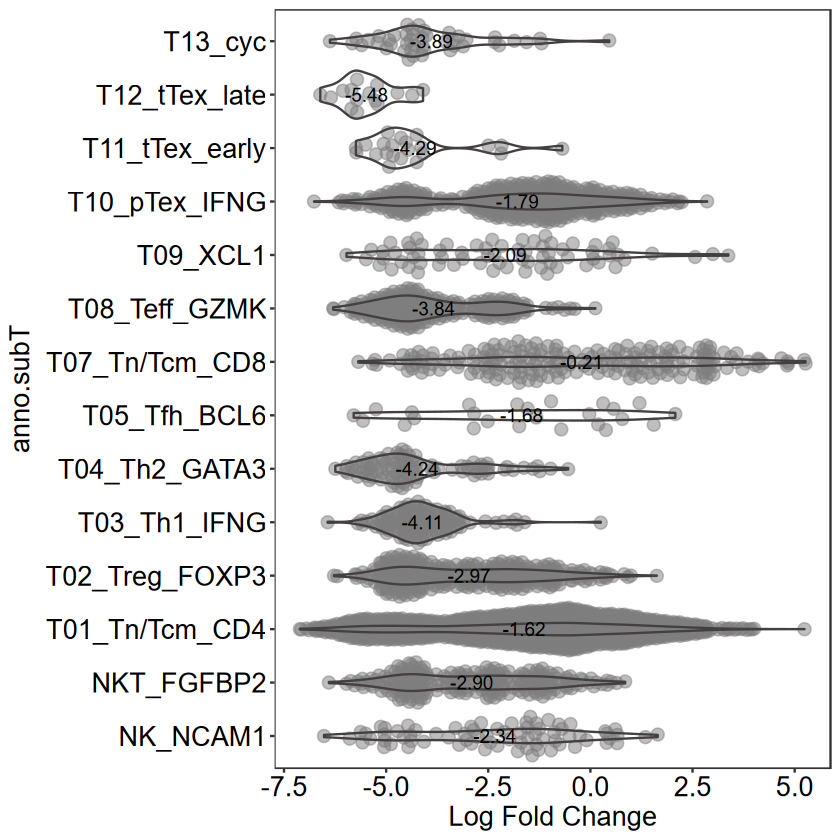

In [30]:
p